In [1]:
import pandas as pd

In [2]:
evaluation = pd.read_csv('evaluation.csv')
train = pd.read_csv('train.csv')

In [3]:
evaluation.head(11)

,text,reason,label
0,the app is crashing when i play a vedio,app crashes during playback,1
1,but i want to connect it to the tv from one de...,want compatibility with more smart televisions,0
2,very helpful when and home working remotley,good app for work,0
3,this zoom so called and missed call and mobile...,receiving incorrect phone number message,0
4,one of my favorite apps,good for spending time,0
5,I have enjoyed watching my favorite shows and ...,good to watch shows,1
6,we have not had internet for a month and a hal...,unable to access live tv,0
7,this is great app when you download the video ...,good app to download videos,1
8,"excellent app for video conferencing, the only...",want to record on ipad,0
9,"also, i can continue watching where i left off.",unable to sync watched episodes,0


In [5]:
noOfdata = 70

In [8]:
from transformers import AutoTokenizer, AutoModel

C:\Users\Asus\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [10]:
tokens = {'input_ids':[],
         'attention_mask':[]}
actual = []
for i in range(noOfdata):
    actual.append(evaluation.loc[i,'label'])
    tokenizedText = tokenizer.encode_plus(evaluation.loc[i,'text'],
                                          max_length=128,
                                          truncation=True,
                                          padding='max_length',
                                          return_tensors='pt')
    tokens['input_ids'].append(tokenizedText['input_ids'][0])
    tokens['attention_mask'].append(tokenizedText['attention_mask'][0])
    

In [11]:
for i in range(noOfdata):
    tokenizedreason = tokenizer.encode_plus(evaluation.loc[i,'reason'],
                                          max_length=128,
                                          truncation=True,
                                          padding='max_length',
                                          return_tensors='pt')
    tokens['input_ids'].append(tokenizedreason['input_ids'][0])
    tokens['attention_mask'].append(tokenizedreason['attention_mask'][0])

In [12]:
len(tokens['input_ids'])

140

In [13]:
import torch

In [14]:
tokens['input_ids'] =  torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

In [15]:
outputs = model(**tokens)

In [16]:
embeddings = outputs.last_hidden_state

In [17]:
attention = tokens['attention_mask']

In [18]:
mask = attention.unsqueeze(-1).expand(embeddings.shape).float() # adds another dimention to attention by just copying the prev val
mask_embedding = embeddings*mask
mask_embedding.shape

torch.Size([140, 128, 768])

In [19]:
summed = torch.sum(mask_embedding, 1) # so this summs up all the 128 lists of tokens
summed.shape # 6, 768

torch.Size([140, 768])

In [20]:
counts = torch.clamp(mask.sum(1), min=1e-9) # any value less than 10**-9 will be clamped
# but mask.sum is not a 1 dimensional tensor so I guess it applies to everyvalue in the tensor
# but since we are only summing 0s and 1s it would imply all the zeroes will turn into 10**9
# so i gues counts[i][j] basically contains no. of tokens in ith sentence
# minis taken to be 1e-9 to avoid divide by zero errors
counts.shape # 6, 768

torch.Size([140, 768])

In [21]:
mean_pooled = summed/counts
mean_pooled = mean_pooled.detach().numpy() # need to detach from a pytorch tensor type

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [23]:
predicted = []
for i in range(int(len(mean_pooled)/2)):
    predicted.append(cosine_similarity([mean_pooled[i]], [mean_pooled[i+70]])[0][0])

In [189]:
precisions = []
recalls = []
f1s = []
supports = []
thresholds = []
j = 1
for threshold in np.linspace(0,1, 21):
    bpredict = []
    for i in predicted:
        if i > threshold:
            bpredict.append(1)
        else:
            bpredict.append(0)
    thresholds.append(threshold)
    precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(actual, bpredict)
    precisions.append(precision[j])
    recalls.append(recall[j])
    f1s.append(f1[j])
    supports.append(support[j])

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\

In [190]:
import matplotlib.pyplot as plt
import numpy as np

In [191]:
f1s = np.array(f1s)
precisions = np.array(precisions)
recalls = np.array(recalls)
supports = np.array(supports)
thresholds = np.array(thresholds)

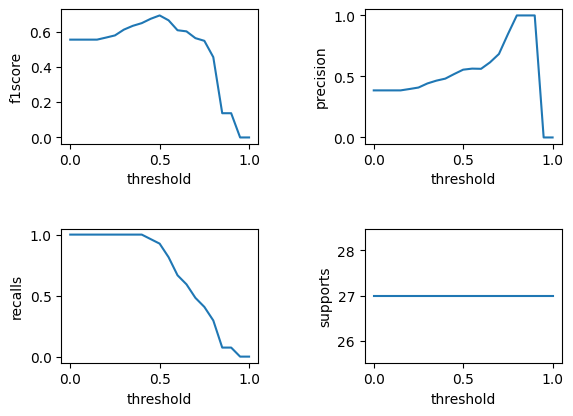

In [192]:
figure, axis = plt.subplots(2, 2)
  
axis[0, 0].plot(thresholds, f1s)
axis[0, 0].set_xlabel("threshold")
axis[0, 0].set_ylabel("f1score")

  
axis[0, 1].plot(thresholds, precisions)
axis[0, 1].set_xlabel("threshold")
axis[0, 1].set_ylabel("precision")

axis[1, 0].plot(thresholds, recalls)
axis[1, 0].set_xlabel("threshold")
axis[1, 0].set_ylabel("recalls")
  
axis[1, 1].plot(thresholds, supports)
axis[1, 1].set_xlabel("threshold")
axis[1, 1].set_ylabel("supports")

figure.tight_layout(pad=3.0)

In [193]:
maxf1 = [max(f1s), thresholds[np.argmax(f1s)]]
maxprecisions = [max(precisions), thresholds[np.argmax(precisions)]]
maxrecalls = [max(recalls), thresholds[np.argmax(recalls)]]
print(maxf1, maxprecisions, maxrecalls)

[0.6944444444444444, 0.5] [1.0, 0.8] [1.0, 0.0]


In [ ]:
# high support = high false positive, good at predicting positve
# high recall = high false negative, goot at predicting negative

In [200]:
precisions[np.argmax(f1s)]

0.5555555555555556

In [201]:
recalls[np.argmax(f1s)]

0.9259259259259259